In [48]:
import gymnasium as gym
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [88]:
import gymnasium as gym
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

def one_hot(n, i):
    vec = np.zeros(n)
    vec[i] = 1
    return vec

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def epsilon_greedy_policy(Q, state, nA, epsilon=0.1):
    policy = np.ones(nA) * epsilon / nA
    best_action = np.argmax(Q[state])
    policy[best_action] += (1.0 - epsilon)
    return policy

def evaluate_policy(env, Q, s0, gamma=0.99, num_episodes=100):
    total_rewards = 0
    for _ in tqdm(range(num_episodes)):
        state = s0
        done = False
        episode_rewards = 0
        discount_factor = 1

        while not done:
            action = np.argmax(Q[state])
            next_state, reward, done, _, _ = env.step(action)
            episode_rewards += discount_factor * reward
            discount_factor *= gamma
            state = next_state

        total_rewards += episode_rewards

    avg_reward = total_rewards / num_episodes
    print(f"Average reward for policy starting at state {s0}: {avg_reward}")
    return avg_reward

def find_optimal_policy(env, gamma=0.99):
    nA = env.action_space.n
    nS = env.observation_space.n
    V = np.zeros(nS)
    Q = np.zeros((nS, nA))

    for i in range(1000):  # A large number to ensure convergence
        for s in range(nS):
            Q[s] = [sum([p * (r + gamma * V[s_])
                         for p, s_, r, _ in env.P[s][a]]) for a in range(nA)]
        V = np.max(Q, axis=1)

    policy = np.argmax(Q, axis=1)
    return policy, Q, V

env = gym.make('FrozenLake-v1', is_slippery=False)
env.reset()
print("Environment Check:")
for state in range(env.observation_space.n):
    for action in range(env.action_space.n):
        print(f"State {state}, Action {action}: {env.P[state][action]}")


Environment Check:
State 0, Action 0: [(1.0, 0, 0.0, False)]
State 0, Action 1: [(1.0, 4, 0.0, False)]
State 0, Action 2: [(1.0, 1, 0.0, False)]
State 0, Action 3: [(1.0, 0, 0.0, False)]
State 1, Action 0: [(1.0, 0, 0.0, False)]
State 1, Action 1: [(1.0, 5, 0.0, True)]
State 1, Action 2: [(1.0, 2, 0.0, False)]
State 1, Action 3: [(1.0, 1, 0.0, False)]
State 2, Action 0: [(1.0, 1, 0.0, False)]
State 2, Action 1: [(1.0, 6, 0.0, False)]
State 2, Action 2: [(1.0, 3, 0.0, False)]
State 2, Action 3: [(1.0, 2, 0.0, False)]
State 3, Action 0: [(1.0, 2, 0.0, False)]
State 3, Action 1: [(1.0, 7, 0.0, True)]
State 3, Action 2: [(1.0, 3, 0.0, False)]
State 3, Action 3: [(1.0, 3, 0.0, False)]
State 4, Action 0: [(1.0, 4, 0.0, False)]
State 4, Action 1: [(1.0, 8, 0.0, False)]
State 4, Action 2: [(1.0, 5, 0.0, True)]
State 4, Action 3: [(1.0, 0, 0.0, False)]
State 5, Action 0: [(1.0, 5, 0, True)]
State 5, Action 1: [(1.0, 5, 0, True)]
State 5, Action 2: [(1.0, 5, 0, True)]
State 5, Action 3: [(1.0, 5

/Users/yanis/miniforge3/envs/cs234_hw3/lib/python3.8/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.P to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.P` for environment variables or `env.get_wrapper_attr('P')` that will search the reminding wrappers.
  logger.warn(


In [68]:
def projected_gradient_ascent(env, s0, gamma=0.99, alpha=0.5, epsilon=0.01, max_iterations=10000):
    nA = env.action_space.n
    nS = env.observation_space.n
    Q = np.zeros((nS, nA))
    iteration_count = 0

    optimal_policy, optimal_Q, optimal_V = find_optimal_policy(env)
    V_star_s0 = optimal_V[s0]

    while True:
        iteration_count += 1
        state, _ = env.reset()
        done = False

        while not done:
            policy = epsilon_greedy_policy(Q, state, nA)
            action = np.random.choice(np.arange(nA), p=policy)
            next_state, reward, done, _, _ = env.step(action)
            
            best_next_action = np.argmax(Q[next_state])
            td_target = reward + gamma * Q[next_state][best_next_action]
            td_error = td_target - Q[state][action]
            Q[state][action] += alpha * td_error

            state = next_state

        V_pi_s0 = evaluate_policy(env, Q, s0, gamma)
        print(f"Iteration {iteration_count}, V_pi_s0: {V_pi_s0:.4f}, V_star_s0: {V_star_s0:.4f}, TD Error: {td_error:.4f}")
        if V_star_s0 - V_pi_s0 <= epsilon or iteration_count >= max_iterations:
            break

    return Q, iteration_count


In [69]:
def softmax_policy_gradient(env, s0, gamma=0.99, alpha=0.1, epsilon=0.01, max_iterations=10000):
    nA = env.action_space.n
    nS = env.observation_space.n
    theta = np.zeros((nS, nA))
    iteration_count = 0

    optimal_policy, optimal_Q, optimal_V = find_optimal_policy(env)
    V_star_s0 = optimal_V[s0]

    while True:
        iteration_count += 1
        state, _ = env.reset()
        done = False

        while not done:
            probs = softmax(theta[state])
            action = np.random.choice(np.arange(nA), p=probs)
            next_state, reward, done, _, _ = env.step(action)
            
            best_next_action = np.argmax(theta[next_state])
            td_target = reward + gamma * theta[next_state][best_next_action]
            td_error = td_target - theta[state][action]

            gradient = one_hot(nA, action) - probs
            theta[state] += alpha * td_error * gradient

            state = next_state

        Q = {s: softmax(theta[s]) for s in range(nS)}
        V_pi_s0 = evaluate_policy(env, Q, s0, gamma)
        print(f"Iteration {iteration_count}, V_pi_s0: {V_pi_s0:.4f}, V_star_s0: {V_star_s0:.4f}")
        if V_star_s0 - V_pi_s0 <= epsilon or iteration_count >= max_iterations:
            break

    return theta, iteration_count


In [70]:
def natural_policy_gradient(env, s0, gamma=0.99, alpha=0.1, epsilon=0.01, max_iterations=10000):
    nA = env.action_space.n
    nS = env.observation_space.n
    theta = np.zeros((nS, nA))
    iteration_count = 0

    optimal_policy, optimal_Q, optimal_V = find_optimal_policy(env)
    V_star_s0 = optimal_V[s0]

    while True:
        iteration_count += 1
        state, _ = env.reset()
        done = False
        I = 1

        while not done:
            probs = softmax(theta[state])
            action = np.random.choice(np.arange(nA), p=probs)
            next_state, reward, done, _, _ = env.step(action)
            
            best_next_action = np.argmax(theta[next_state])
            td_target = reward + gamma * np.max(theta[next_state])
            td_error = td_target - theta[state][action]

            gradient = one_hot(nA, action) - probs
            theta[state] += alpha * I * td_error * gradient
            I *= gamma

            state = next_state

        Q = {s: softmax(theta[s]) for s in range(nS)}
        V_pi_s0 = evaluate_policy(env, Q, s0, gamma)
        print(f"Iteration {iteration_count}, V_pi_s0: {V_pi_s0:.4f}, V_star_s0: {V_star_s0:.4f}")
        if V_star_s0 - V_pi_s0 <= epsilon or iteration_count >= max_iterations:
            break

    return theta, iteration_count


In [71]:
env = gym.make('FrozenLake-v1', is_slippery=False)
s0 = 0 

Q_pga, iterations_pga = projected_gradient_ascent(env, s0)
reward_pga = evaluate_policy(env, Q_pga, s0)

theta_spg, iterations_spg = softmax_policy_gradient(env, s0)
Q_spg = {s: softmax(theta_spg[s]) for s in range(env.observation_space.n)}
reward_spg = evaluate_policy(env, Q_spg, s0)

theta_npg, iterations_npg = natural_policy_gradient(env, s0)
Q_npg = {s: softmax(theta_npg[s]) for s in range(env.observation_space.n)}
reward_npg = evaluate_policy(env, Q_npg, s0)

print(f"Projected Gradient Ascent: Reward = {reward_pga}, Iterations = {iterations_pga}")
print(f"Softmax Policy Gradient: Reward = {reward_spg}, Iterations = {iterations_spg}")
print(f"Natural Policy Gradient: Reward = {reward_npg}, Iterations = {iterations_npg}")

D_inf = 1
S = env.observation_space.n
A = env.action_space.n
gamma = 0.99
epsilon = 0.01

def theoretical_iterations_pga(D_inf, S, A, gamma, epsilon):
    return (D_inf**2 * S * A) / ((1 - gamma)**6 * epsilon**2)

def theoretical_iterations_spg(D_inf, S, A, gamma, epsilon):
    return (D_inf**2 * S**2 * A**2) / ((1 - gamma)**6 * epsilon**2)

def theoretical_iterations_npg(gamma, epsilon):
    return 2 / ((1 - gamma)**2 * epsilon)

theoretical_pga = theoretical_iterations_pga(D_inf, S, A, gamma, epsilon)
theoretical_spg = theoretical_iterations_spg(D_inf, S, A, gamma, epsilon)
theoretical_npg = theoretical_iterations_npg(gamma, epsilon)

print(f"Theoretical Projected Gradient Ascent: {theoretical_pga}")
print(f"Theoretical Softmax Policy Gradient: {theoretical_spg}")
print(f"Theoretical Natural Policy Gradient: {theoretical_npg}")


Average reward for policy starting at state 0: 0.0
Iteration 1, V_pi_s0: 0.0000, V_star_s0: 0.9510, TD Error: 0.0000
Average reward for policy starting at state 0: 0.0
Iteration 2, V_pi_s0: 0.0000, V_star_s0: 0.9510, TD Error: 0.0000
Average reward for policy starting at state 0: 0.0
Iteration 3, V_pi_s0: 0.0000, V_star_s0: 0.9510, TD Error: 0.0000
Average reward for policy starting at state 0: 0.0
Iteration 4, V_pi_s0: 0.0000, V_star_s0: 0.9510, TD Error: 0.0000
Average reward for policy starting at state 0: 0.0
Iteration 5, V_pi_s0: 0.0000, V_star_s0: 0.9510, TD Error: 0.0000
Average reward for policy starting at state 0: 0.0
Iteration 6, V_pi_s0: 0.0000, V_star_s0: 0.9510, TD Error: 0.0000
Average reward for policy starting at state 0: 0.0
Iteration 7, V_pi_s0: 0.0000, V_star_s0: 0.9510, TD Error: 0.0000
Average reward for policy starting at state 0: 0.0
Iteration 8, V_pi_s0: 0.0000, V_star_s0: 0.9510, TD Error: 0.0000
Average reward for policy starting at state 0: 0.0
Iteration 9, 

KeyboardInterrupt: 

In [ ]:
env = gym.make('FrozenLake-v1')
gamma_values = [0.2, 0.5, 0.7]
epsilon_values = [0.1]

results = []

for gamma in gamma_values:
    for epsilon in epsilon_values:
        Q_pga, iterations_pga = projected_gradient_ascent(env, gamma=gamma, epsilon=epsilon)
        reward_pga = evaluate_policy(env, Q_pga)

        theta_spg, iterations_spg = softmax_policy_gradient(env, gamma=gamma)
        Q_spg = {s: softmax(theta_spg[s]) for s in range(env.observation_space.n)}
        reward_spg = evaluate_policy(env, Q_spg)

        theta_npg, iterations_npg = natural_policy_gradient(env, gamma=gamma)
        Q_npg = {s: softmax(theta_npg[s]) for s in range(env.observation_space.n)}
        reward_npg = evaluate_policy(env, Q_npg)

        D_inf = 1
        S = env.observation_space.n
        A = env.action_space.n
        print(D_inf, S, A, gamma, epsilon)

        theoretical_pga = theoretical_iterations_pga(D_inf, S, A, gamma, epsilon)
        theoretical_spg = theoretical_iterations_spg(D_inf, S, A, gamma, epsilon)
        theoretical_npg = theoretical_iterations_npg(gamma, epsilon)

        results.append({
            'gamma': gamma,
            'epsilon': epsilon,
            'Projected Gradient Ascent': {'empirical': iterations_pga, 'theoretical': theoretical_pga, 'reward': reward_pga},
            'Softmax Policy Gradient': {'empirical': iterations_spg, 'theoretical': theoretical_spg, 'reward': reward_spg},
            'Natural Policy Gradient': {'empirical': iterations_npg, 'theoretical': theoretical_npg, 'reward': reward_npg},
        })

# Print results
for result in results:
    print(f"Gamma: {result['gamma']}, Epsilon: {result['epsilon']}")
    for method in ['Projected Gradient Ascent', 'Softmax Policy Gradient', 'Natural Policy Gradient']:
        print(f"{method}: Empirical = {result[method]['empirical']}, Theoretical = {result[method]['theoretical']}, Reward = {result[method]['reward']}")
    print()

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

1 16 4 0.2 0.1


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

1 16 4 0.5 0.1


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

1 16 4 0.7 0.1
Gamma: 0.2, Epsilon: 0.1
Projected Gradient Ascent: Empirical = 14793, Theoretical = 24414.06249999999, Reward = 0.0
Softmax Policy Gradient: Empirical = 7352, Theoretical = 1562499.9999999993, Reward = 0.08
Natural Policy Gradient: Empirical = 7417, Theoretical = 31.249999999999993, Reward = 0.08

Gamma: 0.5, Epsilon: 0.1
Projected Gradient Ascent: Empirical = 14543, Theoretical = 409599.99999999994, Reward = 0.0
Softmax Policy Gradient: Empirical = 7736, Theoretical = 26214399.999999996, Reward = 0.06
Natural Policy Gradient: Empirical = 7583, Theoretical = 80.0, Reward = 0.05

Gamma: 0.7, Epsilon: 0.1
Projected Gradient Ascent: Empirical = 14703, Theoretical = 8779149.51989025, Reward = 0.0
Softmax Policy Gradient: Empirical = 7533, Theoretical = 561865569.272976, Reward = 0.05
Natural Policy Gradient: Empirical = 7650, Theoretical = 222.22222222222214, Reward = 0.03



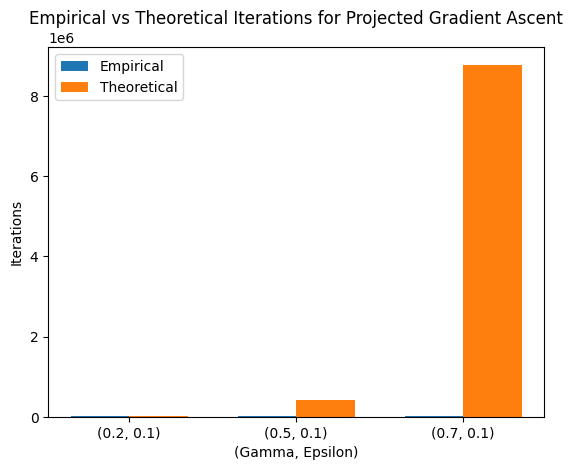

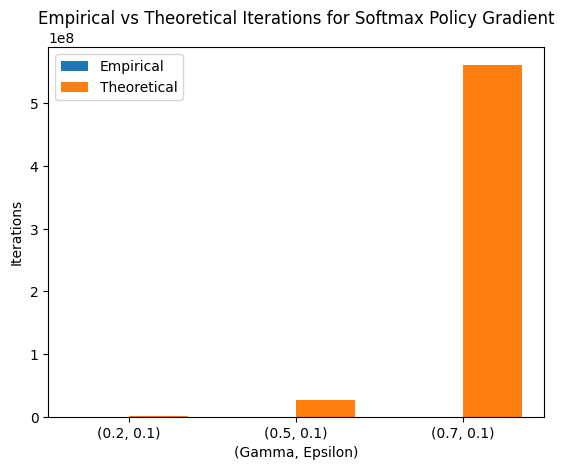

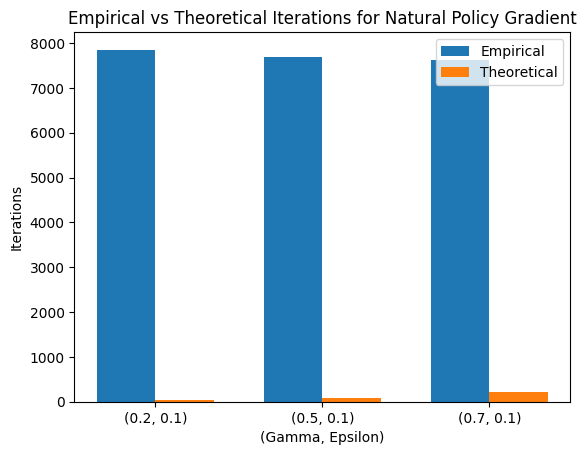

In [20]:
def plot_results(results):
    for method in ['Projected Gradient Ascent', 'Softmax Policy Gradient', 'Natural Policy Gradient']:
        empirical_values = [result[method]['empirical'] for result in results]
        theoretical_values = [result[method]['theoretical'] for result in results]
        gamma_epsilon_pairs = [(result['gamma'], result['epsilon']) for result in results]

        x = np.arange(len(gamma_epsilon_pairs))
        width = 0.35

        fig, ax = plt.subplots()
        rects1 = ax.bar(x - width/2, empirical_values, width, label='Empirical')
        rects2 = ax.bar(x + width/2, theoretical_values, width, label='Theoretical')

        ax.set_xlabel('(Gamma, Epsilon)')
        ax.set_ylabel('Iterations')
        ax.set_title(f'Empirical vs Theoretical Iterations for {method}')
        ax.set_xticks(x)
        ax.set_xticklabels(gamma_epsilon_pairs)
        ax.legend()

        plt.show()

plot_results(results)

In [105]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

def one_hot(n, i):
    vec = np.zeros(n)
    vec[i] = 1
    return vec

def epsilon_greedy_policy(Q, state, nA, epsilon=0.1):
    policy = np.ones(nA) * epsilon / nA
    best_action = np.argmax(Q[state])
    policy[best_action] += (1.0 - epsilon)
    return policy

def value_iteration(env, gamma=0.99, epsilon=0.01, max_iterations=10000):
    nA = env.action_space.n
    nS = env.observation_space.n
    V = np.zeros(nS)

    for _ in range(max_iterations):
        prev_V = np.copy(V)
        for state in range(nS):
            Q_values = np.zeros(nA)
            for action in range(nA):
                q_value = 0
                for prob, next_state, reward, done in env.P[state][action]:
                    q_value += prob * (reward + gamma * prev_V[next_state] * (not done))
                Q_values[action] = q_value
            V[state] = np.max(Q_values)
        if np.max(np.abs(prev_V - V)) < epsilon:
            break

    return V

def evaluate_policy(env, Q, num_episodes=100, max_steps_per_episode=100):
    total_rewards = 0
    for _ in range(num_episodes):
        state, _ = env.reset()
        done = False
        steps = 0
        while not done and steps < max_steps_per_episode:
            action = np.argmax(Q[state])
            next_state, reward, done, _, _ = env.step(action)
            total_rewards += reward
            state = next_state
            steps += 1
    return total_rewards / num_episodes



def projected_gradient_ascent(env, gamma=0.99, alpha=0.1, epsilon=0.01, max_iterations=10000, s0=0):
    nA = env.action_space.n
    nS = env.observation_space.n
    Q = np.zeros((nS, nA))
    iteration_count = 0
    V_star = value_iteration(env, gamma, epsilon, max_iterations)[s0]
    print(f"V_star: {V_star}")

    for _ in tqdm(range(max_iterations)):
        iteration_count += 1
        state, _ = env.reset()
        done = False

        while not done:
            policy = epsilon_greedy_policy(Q, state, nA)
            action = np.random.choice(np.arange(nA), p=policy)
            next_state, reward, done, _, _ = env.step(action)
            
            best_next_action = np.argmax(Q[next_state])
            td_target = reward + gamma * Q[next_state][best_next_action]
            td_error = td_target - Q[state][action]
            Q[state][action] += alpha * td_error

            state = next_state

        # Check the stopping criterion for the fixed state s0
        V_pi = np.max(Q, axis=1)
        print(f"Iteration {iteration_count}, V_pi[s0]: {V_pi}")
        if V_star - V_pi[s0] <= epsilon:
            break

    return Q, iteration_count

# Parameters
env = gym.make('FrozenLake-v1', is_slippery=False)
gamma = 0.99
alpha = 1
epsilon = 0.5
s0 = 1  # Fixed starting state

# Run Projected Gradient Ascent
Q_pga, iterations_pga = projected_gradient_ascent(env, gamma, alpha, epsilon, s0=s0)
reward_pga = evaluate_policy(env, Q_pga)

print(f"Projected Gradient Ascent: Reward = {reward_pga}, Iterations = {iterations_pga}")

# Theoretical Iterations
D_inf = 0.1
S = env.observation_space.n
A = env.action_space.n

def theoretical_iterations_pga(D_inf, S, A, gamma, epsilon):
    return (D_inf**2 * S * A) / ((1 - gamma)**6 * epsilon**2)

theoretical_pga = theoretical_iterations_pga(D_inf, S, A, gamma, epsilon)
print(f"Theoretical Projected Gradient Ascent Iterations: {theoretical_pga}")

# Plotting
labels = ['Empirical', 'Theoretical']
values = [iterations_pga, theoretical_pga]

plt.bar(labels, values)
plt.xlabel('Iteration Type')
plt.ylabel('Number of Iterations')
plt.title('Empirical vs Theoretical Iterations for Projected Gradient Ascent')
plt.show()


V_star: 0.96059601


/Users/yanis/miniforge3/envs/cs234_hw3/lib/python3.8/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.P to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.P` for environment variables or `env.get_wrapper_attr('P')` that will search the reminding wrappers.
  logger.warn(


  0%|          | 0/10000 [00:00<?, ?it/s]

Iteration 1, V_pi[s0]: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Iteration 2, V_pi[s0]: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Iteration 3, V_pi[s0]: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Iteration 4, V_pi[s0]: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Iteration 5, V_pi[s0]: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Iteration 6, V_pi[s0]: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Iteration 7, V_pi[s0]: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Iteration 8, V_pi[s0]: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Iteration 9, V_pi[s0]: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Iteration 10, V_pi[s0]: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Iteration 11, V_pi[s0]: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Iteration 12, V_pi[s0]: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Iteration 13, V_pi[s0]: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Iteration 14, V_pi[s0]: [0. 0. 0. 0. 0. 0. 0. 0

KeyboardInterrupt: 